# Import

In [10]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
import shap; shap.initjs()
import matplotlib.pyplot as plt

# Useful functions

In [55]:
def _scale_right(X, ylim):
    '''
    Scale the right column of X to make it proportional to the left column of X.
    '''
    left, right = X.columns
    ranges = ylim.diff().abs().iloc[1,:]    
    X_right_scaled = (X[right] - ylim.loc['min', right]) / ranges[right] * ranges[left] + ylim.loc['min', left]
    return pd.concat([X[left], X_right_scaled], axis = 1)

def _group_stats(X, group):
    '''
    Get statistics (25th percentile, median, and 75th percentile) of numeric variables contained in "X".
    Rows of "X" are grouped by "group"
    '''
    iqr = X.groupby(group).describe().loc[:, (slice(None), ['25%', '50%', '75%'])]\
        .unstack().unstack(level = 0).swaplevel()
    ylim = iqr.describe().loc[['min', 'max'], :]
    buffer = .05 * (ylim.loc['max', :] - ylim.loc['min', :])
    ylim.loc['min', :] -= buffer
    ylim.loc['max', :] += buffer
    return iqr, ylim

def _newline(s, after = 20):
    '''
    String with new line separator after "after" characters.
    '''
    out = s[:after]
    for i in range(1, len(s) // after + 1):
        out += '\n' + s[i*after:(i+1)*after]
    return out

def parallel_plot(X, group = None, colors = None, suptitle = None, savefig = None):
    '''
    Make parallel plot of numeric variables contained in "X". Observations are grouped by "group"
    '''
    if group is None:
        group = pd.Series(X.index, index = X.index)
    group_names = group.value_counts().index.to_list()
    iqr, ylim = _group_stats(X, group)

    fig, axes = plt.subplots(1, len(X.columns) - 1, figsize = (1.5 * len(X.columns), 3))
    plt.subplots_adjust(wspace = 0)
    fig.suptitle(suptitle)

    cols_left = X.columns[:-1] if X.shape[1] > 2 else [X.columns[0]]
    cols_right = X.columns[1:] if X.shape[1] > 2 else [X.columns[1]]
    axes = axes if X.shape[1] > 2 else [axes]

    for ax, left, right in zip(axes, cols_left, cols_right):
        ax.set(ylim = ylim[left], xlim = [0, 1], xticks = [0], xticklabels = [_newline(left)])
        ax.grid(False)
        y = _scale_right(iqr[[left, right]], ylim[[left, right]])
        for group_name in group_names:
            ax.plot([0, 1], y.loc[(group_name, '50%'), :], color = colors[group_name], lw = 2, label = group_name) 
            ax.fill_between([0, 1], y1 = y.loc[(group_name, '25%'), :], y2 = y.loc[(group_name, '75%'), :], color = colors[group_name], alpha = .2)
            
    axes[-1].twinx().set(ylim = ylim.iloc[:, -1], xticks = [0, 1], xticklabels = X.columns[-2:])    
    axes[-1].legend(bbox_to_anchor = [1.3, 0.5], loc = 'center left')
    
    if savefig is not None:
        fig.savefig(savefig, dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()

def main_symptoms(series, level = 0, return_eligible = True, select_top = 5):
    '''
    Select main symptoms.
    '''
    series_asc = series.sort_values()
    index_asc = series_asc.index
    select_top = min(select_top, len(series))
    is_main_symptom = ((series_asc > 0) & (series_asc.cumsum() > level) & (series_asc >= series_asc.iloc[-select_top]))
    return is_main_symptom[series.index]

# Download data

In [56]:
# !kaggle datasets download -d mnassrib/telecom-churn-datasets

In [57]:
df = pd.read_csv('churn-bigml-80.csv').replace({'Yes': 1, 'No': 0, True: 1, False: 0})
X = df.drop('Churn', axis = 1)
y = df['Churn']

# Fit model and get SHAP

In [58]:
cat_features = [0, 2] # State, Area code
cat = CatBoostClassifier(cat_features = cat_features, silent = True).fit(X, y)

#probas = pd.Series(cat.predict_proba(x)[:,1],index=x.index)
shap_values = pd.DataFrame(
    cat.get_feature_importance(data = Pool(X, cat_features = cat_features), type = 'ShapValues')[:,:-1], 
    columns = X.columns, 
    index = X.index
)
shap_sum = shap_values.sum(axis = 1)

# Compare data and SHAP

In [59]:
X_obs = X.loc[950,:].to_frame().T
shap_obs = shap_values.loc[950,:].to_frame().T.round(2).astype(str)
X_obs.index = ['Observed']
shap_obs.index = ['SHAP']
shap_obs = shap_obs.style.apply(lambda x:["background:pink" if v[0]!='-' else "background:lightblue" for v in x], axis = 1)

In [60]:
X_obs

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
Observed,IL,78,415,1,0,0,236.8,141,40.26,265.3,101,22.55,152.4,77,6.86,9.5,2,2.57,1


In [61]:
shap_obs

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
SHAP,-0.11,-0.02,0.1,3.1,0.2,0.21,0.56,0.16,0.6,0.44,0.04,0.53,-0.35,-0.04,-0.2,-0.08,2.34,-0.06,-0.07


# SHAP's force plot

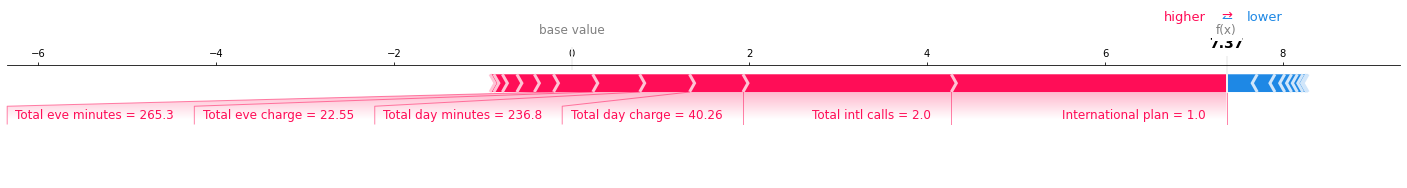

In [62]:
shap.force_plot(
    base_value = 0, 
    shap_values = np.array(shap_values.loc[950,:]), 
    features = X.loc[950,:],
    show = False,
    matplotlib=True
)
plt.tight_layout()

# Pareto effect

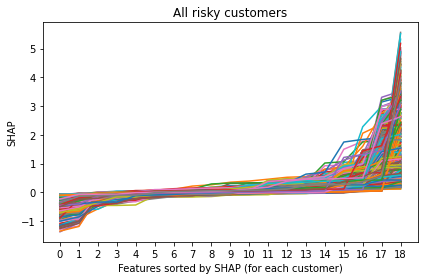

In [63]:
for i in shap_values[shap_sum > 0].index:
    plt.plot(range(shap_values.shape[1]), shap_values.iloc[i, :].sort_values())
plt.xticks(range(shap_values.shape[1]))
plt.title('All risky customers')
plt.ylabel('SHAP')
plt.xlabel('Features sorted by SHAP (for each customer)')
plt.tight_layout()

# Single customer

In [64]:
ix = 950

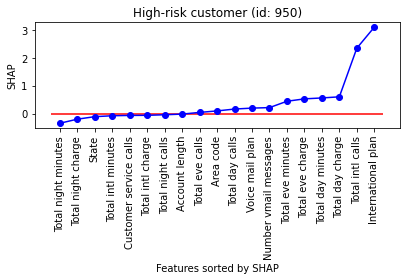

In [65]:
ss = shap_values.loc[ix,:].sort_values()

fig, ax = plt.subplots(figsize = (6, 4))

ax.hlines(0, -.5, shap_values.shape[1] - .5, color = 'red')
ax.plot(range(shap_values.shape[1]),ss, '-bo')
ax.set_ylabel('SHAP')
ax.set_xticks(range(shap_values.shape[1]))
ax.set_xticklabels(ss.index, rotation = 90)
ax.set_xlabel('Features sorted by SHAP')
ax.set_title('High-risk customer (id: {})'.format(ix))

plt.tight_layout()

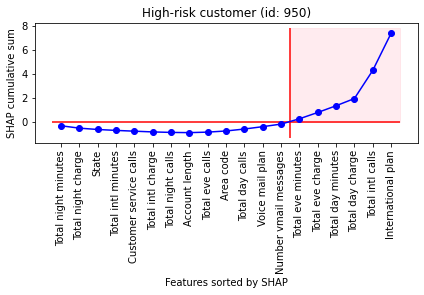

In [66]:
cs = ss.cumsum()
range_cs = max(cs) - min(cs)

fig, ax = plt.subplots(figsize = (6, 4.2))

ax.fill_between([shap_values.shape[1] - (cs > 0).sum() - .5, shap_values.shape[1] - .5], [0] * 2, [max(cs) + .05 * range_cs] * 2, color = 'pink', alpha = .3)
ax.vlines(shap_values.shape[1] - (cs > 0).sum() - .5, min(cs) - .05 * range_cs, max(cs) + .05 * range_cs, color = 'red')
ax.hlines(0, -.5, shap_values.shape[1] - .5, color = 'red')
ax.plot(range(shap_values.shape[1]), cs, '-bo')
ax.set_ylabel('SHAP cumulative sum')
ax.set_xticks(range(shap_values.shape[1]))
ax.set_xticklabels(cs.index, rotation = 90)
ax.set_xlabel('Features sorted by SHAP')
ax.set_title('High-risk customer (id: {})'.format(ix))

plt.tight_layout()

# Parallel plot on single customer

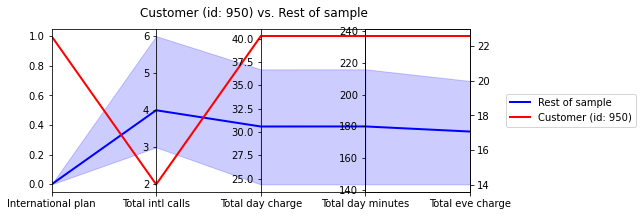

In [67]:
cols_sorted = shap_values.loc[ix, :][main_symptoms(shap_values.loc[ix, :])].sort_values(ascending = False).index.to_list()
cluster_name = 'Customer (id: {})'.format(ix)
pop_name = 'Rest of sample'

parallel_plot(
    X[cols_sorted],
    group = pd.Series(
        shap_values.index == ix, index = shap_values.index
    ).replace({True: cluster_name, False: pop_name}), 
    colors = {cluster_name: 'red', pop_name: 'blue'},
    suptitle = 'Customer (id: {}) vs. Rest of sample'.format(ix),
    savefig = 'customer_parallel_plot.png'
)

# From a single customer to groups of customers

In [68]:
is_trigger = shap_values.apply(main_symptoms, axis = 1) * 1
pattern = is_trigger.astype(str).apply(lambda s: s.sum(), axis = 1)
is_trigger[shap_sum > 0].head(8).style.apply(lambda x:["background:orangered" if v>.5 else "background:lightgrey" for v in x], axis = 1)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
26,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
28,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0
35,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


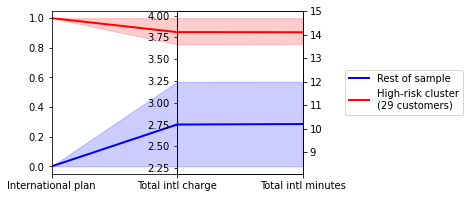

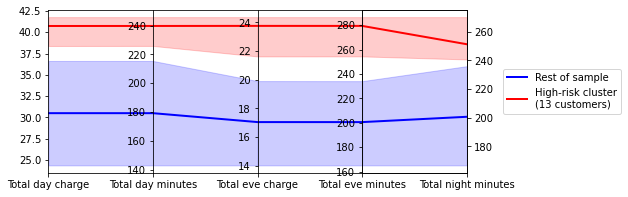

In [70]:
patterns = [
    '0001000000000001010',
    '0000001011011000000'
]

for enum, p in enumerate(patterns):
    if np.array([int(i) for i in p]).sum() > 1:
        select_row = pattern == p
        select_col = (is_trigger[select_row].head(1) > .5).iloc[0, :]
        cols_sorted = shap_values.loc[select_row, select_col].sum().sort_values(ascending = False).index.to_list()
        cluster_name = 'High-risk cluster\n({} customers)'.format(select_row.sum())
        pop_name = 'Rest of sample'
        parallel_plot(
            X[cols_sorted],
            group = select_row.replace({True: cluster_name, False: pop_name}), 
            colors = {cluster_name: 'red', pop_name: 'blue'},
        )